# Temporal Fusion Transformer para la composición de portafolios

Crear un modelo que permita estimar el riesgo y el retorno de un conjunto de acciones de la bolsa, que le brinde al usuario la información para definir la composición de un portafolio.
Para ello se entrenará un modelo de aprendizaje profundo que estime los valores de riesgo (varianza en el volumen transado) y retorno (precio diario de cierre) para un periodo de un trimestre, tomando como base el desempeño del índice S&P500 de la Bolsa de New York.

In [ ]:
#!pip install -q yfinance pytorch_forecasting

In [124]:
#import gc
import lightning.pytorch as pl
#import logging
#import mlflow
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import tensorboard as tb 
import tensorflow as tf 
import torch
#import warnings
import yfinance as yf
#from datetime import datetime
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, \
    TimeSeriesDataSet, GroupNormalizer, EncoderNormalizer, MultiNormalizer, \
    SMAPE, QuantileLoss
from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.preprocessing import StandardScaler

In [2]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
pl.seed_everything(30)

Global seed set to 30


30

## Captura y procesamiento de datos

Descarga los datos de Yaho Finance mediante la libreria yfinance, se descargan las 50 acciones con mayor volumen en indice S&P500 de la bolsa de valores de USA para el entrenamiento

In [19]:
COLUMNS = ["Close", "Open", "Volume"]
TICKERS = ["SPY"] + ["AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", 
                     "GOOG", "META", "TSLA", "UNH", "XOM", "JNJ", 
                     "JPM", "V", "PG", "LLY", "AVGO", "MA", "HD", 
                     "MRK", "CVX", "PEP", "ABBV", "KO", "COST", 
                     "CRM", "MCD", "PFE", "CSCO", "WMT", "AMD", 
                     "TMO", "BAC", "ACN", "ADBE", "ABT", "NFLX", 
                     "LIN", "CMCSA", "ORCL", "DIS", "TXN", "WFC", 
                     "DHR", "VZ", "NEE", "PM", "RTX", "BMY", "NKE"]
data = yf.download(TICKERS, period = "max", repair = True)
data = data.dropna()

[*********************100%***********************]  50 of 50 completed


Esta funcion procesa:
* El precio de cierre de la accion obteniendo el retorno logaritmico para cada dia
* El volumen de la accion obteniendo el valor logaritmico de mismo y haciendo una estadarizacion de los valores
* El precio de apertura de la accion calculando la razon entre el precio de cierre y apertura

In [4]:
def close_volume_open(df: pd.DataFrame):
    res = df.copy()
    res.Close = np.log(res.Close + 1e-8).diff().fillna(method='bfill')
    res.Volume = np.log(res.Volume + 1e-8)
    scaler = StandardScaler().fit(res[:int(len(res)*0.7)]['Volume'].to_numpy())
    res.Volume = pd.DataFrame(
        data=scaler.transform(res['Volume'].to_numpy()),
        columns=res.Volume.columns, index=res.index)
    res.Open = df.Open / df.Close
    return res

Esta funcion concatena las distintas columnas de cada accion en las columnas principales definidas

In [5]:
def multiple_ticker(df: pd.DataFrame):
  data_ingest = pd.DataFrame(columns=['Date', 'Ticker'])
  for column in COLUMNS:
    df2 = pd.melt(df[column], value_vars=TICKERS, var_name='Ticker', value_name=column, ignore_index=False).reset_index()
    if(data_ingest.empty):
      data_ingest = pd.concat( [data_ingest, df2] )
    else:
      data_ingest = pd.merge(data_ingest, df2, on=["Date", "Ticker"])
  return data_ingest

Luego pre procesamos los datos y obtenemos caracteristicas de las fechas que permitan encontrar patrones periodicos

In [18]:
def procesing_data(df: pd.DataFrame)->pd.DataFrame:
    """Esta funcion procesa los datos de las acciones y añade caracteristicas 
    de tiempo (dia del mes, mes de año, dia de la semana, dia del año) para entrenar el modelo """
    DATE_COLUMNS = ['Date_day', 'Date_month', 'Date_day_week', 'Date_day_year', 'Time_idx']
    data_ingest = close_volume_open(df)
    data_ingest = multiple_ticker(data_ingest)
    data_ingest[DATE_COLUMNS[0]] = data_ingest.Date.dt.day.astype(str)  
    data_ingest[DATE_COLUMNS[1]] = data_ingest.Date.dt.month.astype(str)  
    data_ingest[DATE_COLUMNS[2]] = data_ingest.Date.dt.day_of_week.astype(str)  
    data_ingest[DATE_COLUMNS[3]] = data_ingest.Date.dt.day_of_year.astype(str)  
    data_ingest[DATE_COLUMNS[4]] = data_ingest.groupby("Ticker")["Date"].rank(method="dense").astype(int)
    data_ingest.sort_values(by=['Date', 'Ticker'], inplace=True, ignore_index=True)
    return data_ingest

In [29]:
processed_data = procesing_data(data)
#processed_data.to_parquet('processed_data.parquet')

## Modelo TemporalFusionTransformer 

In [38]:
def split_data(df: pd.DataFrame):
    """Esta funcion divide el conjunto de datos en 3 subconjuntos 
    respectivamente, entrenamiento (70%), validacion(20%) y pruebas(10%)"""
    dates_index = df.Date.unique()
    size = len(dates_index)
    return df[df.Date.isin(dates_index[:int(size*0.7)])], \
    df[df.Date.isin(dates_index[int(size*0.7):int(size*0.9)])], \
    df[df.Date.isin(dates_index[int(size*0.9):])]
train_df, val_df, test_df = split_data(processed_data)

In [21]:
class TftParams(object):
    """Esta clase contiene los parametros necesarios del modelo"""
    def __init__(self):
        self.BATCH_SIZE = 16
        self.NUM_EPOCHS = 120
        self.LEARNING_RATE = 0.0016879719644926218
        self.PATIENCE = 30
        self.DROPOUT = 0.12717796990901462
        self.HIDDEN_LAYER_SIZE = 99
        self.EMBEDDING_DIMENSION = 79
        self.NUM_LSTM_LAYERS = 2
        self.NUM_ATTENTION_HEADS = 1
        self.QUANTILES = [0.1, 0.5, 0.9]
        self.GRADIENT_CLIP_VAL = 0.01002874085767653
    
        self.ENCODER_LEN_MIN = 252 #1 anio
        self.ENCODER_LEN_MAX = 252 #1 anio
        self.DECODER_LEN = 63 # 1 trimestre
        self.TIME_IDX = 'Time_idx'
        self.TARGET = ['Close', 'Volume']
        self.GROUP_ID = ["Ticker"]
        self.STATIC_CATEGORICALS = ["Ticker"]
        self.TIME_KNOW_CATEGORICALS = ['Date_day', 'Date_month', 'Date_day_week', 'Date_day_year']
        self.TIME_KNOW_REALS = ['Time_idx']
        self.TIME_UNKNOW_CATEGORICALS = []
        self.TIME_UNKNOW_REALS = ["Close", "Open", "Volume"]

In [118]:
def getTimeSeriesDataSet(df: pd.DataFrame, params: TftParams):
    normalizer1 = GroupNormalizer(groups=params.GROUP_ID, transformation=None, scale_by_group=True)
    normalizer2 = MultiNormalizer([normalizer1, normalizer1]) #method='identity'
    return TimeSeriesDataSet(
        df,
        time_idx=params.TIME_IDX,
        target=params.TARGET,
        group_ids=params.GROUP_ID, 
        min_encoder_length=params.ENCODER_LEN_MIN,
        max_encoder_length=params.ENCODER_LEN_MAX,
        max_prediction_length=params.DECODER_LEN,
        
        categorical_encoders={params.TIME_KNOW_CATEGORICALS[3]: NaNLabelEncoder(add_nan=True)},
        
        static_categoricals=params.STATIC_CATEGORICALS,
        time_varying_known_categoricals=params.TIME_KNOW_CATEGORICALS,
        time_varying_known_reals=params.TIME_KNOW_REALS,
        time_varying_unknown_categoricals=params.TIME_UNKNOW_CATEGORICALS,
        time_varying_unknown_reals=params.TIME_UNKNOW_REALS,
        
        target_normalizer= normalizer2 if isinstance(params.TARGET, list) else normalizer1,
        lags={'Close': [5, 20]},
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
training = getTimeSeriesDataSet(train_df, TftParams())
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=True, stop_randomization=True)
batch_size = TftParams().BATCH_SIZE
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)
new_params = TftParams()
new_params.ENCODER_LEN_MIN = 180
new_params.ENCODER_LEN_MAX = 180
testing = getTimeSeriesDataSet(test_df, new_params)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/opt/conda/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:318: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


In [ ]:
if True:
    warnings.filterwarnings('ignore')
    logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [74]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=TftParams().PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=TftParams().LEARNING_RATE,
    lstm_layers=TftParams().NUM_LSTM_LAYERS,
    hidden_size=TftParams().HIDDEN_LAYER_SIZE,
    attention_head_size=TftParams().NUM_ATTENTION_HEADS,
    dropout=TftParams().DROPOUT,
    hidden_continuous_size=TftParams().EMBEDDING_DIMENSION,
    output_size=[len(TftParams().QUANTILES), len(TftParams().QUANTILES)],
    loss=QuantileLoss(quantiles=TftParams().QUANTILES),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

trainer = pl.Trainer(
    max_epochs=TftParams().NUM_EPOCHS,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=TftParams().GRADIENT_CLIP_VAL,
    #limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

print(f"Number of parameters in network: {tft.size()/1e6:.2f}M")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 1.11M


## Entrenamiento y optimizacion

Se puede usar OPTUNA para la busqueda de hiperparametros del modelo

In [80]:
opt = optuna.create_study(direction="minimize", pruner=optuna.pruners.SuccessiveHalvingPruner(), study_name='tft_study')

[I 2023-06-07 00:30:14,155] A new study created in memory with name: tft_study


In [ ]:
kwargs = {"loss": QuantileLoss(quantiles=TftParams().QUANTILES)}
study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=20,
        max_epochs=1,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30, #accelerator='gpu', devices=-1,
                            callbacks=[]),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,
        study=opt, 
        timeout=60*60*2, #2 horas
        **kwargs
    )
print('best_trial', study.best_trial.params)

In [ ]:
#mlflow.log_params(TftParams().__dict__)
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

## Validacion

In [96]:
best_tft = torch.load('best(1).ckpt')

In [104]:
base_model = Baseline()
baseline_predictions = base_model.predict(val_dataloader)
actuals = torch.cat([
    torch.cat([y[0][0] for x, y in iter(val_dataloader)]), 
    torch.cat([y[0][1] for x, y in iter(val_dataloader)])])
predictions = best_tft.predict(val_dataloader, mode="prediction")

print(f"Validation median SMAPE loss naive: {SMAPE().loss(actuals, torch.cat(baseline_predictions)).mean(axis = 1).median().item()}")
print(f"Validation median SMAPE loss model: {SMAPE().loss(actuals, torch.cat(predictions)).mean(axis = 1).median().item()}")

Validation median SMAPE loss naive: 1.3802239894866943
Validation median SMAPE loss model: 1.531894564628601


## Prediccion

In [240]:
raw_predictions = best_tft.predict(test_dataloader, mode="raw", return_x=True, return_decoder_lengths=12, num_workers=12)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [206]:
# class PredictionParams(object):
def __init__(self):
    self.TARGET = {TftParams().TARGET[x]:x for x in range(len(TftParams().TARGET))}
    self.STOCK = {TICKERS[x]:x for x in range(len(TICKERS))}
    self.DAYS = [x for x in range(TftParams().DECODER_LEN)]
print(PredictionParams().__dict__)

{'TARGET': {'Close': 0, 'Volume': 1}, 'STOCK': {'SPY': 0, 'AAPL': 1, 'MSFT': 2, 'AMZN': 3, 'NVDA': 4, 'GOOGL': 5, 'GOOG': 6, 'META': 7, 'TSLA': 8, 'UNH': 9, 'XOM': 10, 'JNJ': 11, 'JPM': 12, 'V': 13, 'PG': 14, 'LLY': 15, 'AVGO': 16, 'MA': 17, 'HD': 18, 'MRK': 19, 'CVX': 20, 'PEP': 21, 'ABBV': 22, 'KO': 23, 'COST': 24, 'CRM': 25, 'MCD': 26, 'PFE': 27, 'CSCO': 28, 'WMT': 29, 'AMD': 30, 'TMO': 31, 'BAC': 32, 'ACN': 33, 'ADBE': 34, 'ABT': 35, 'NFLX': 36, 'LIN': 37, 'CMCSA': 38, 'ORCL': 39, 'DIS': 40, 'TXN': 41, 'WFC': 42, 'DHR': 43, 'VZ': 44, 'NEE': 45, 'PM': 46, 'RTX': 47, 'BMY': 48, 'NKE': 49}, 'DAYS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]}


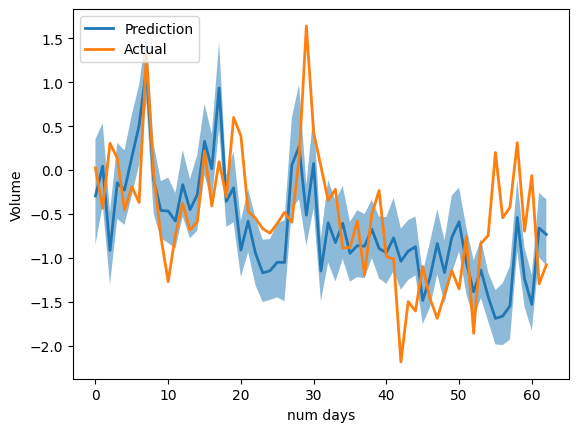

In [232]:
stocks = ["AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "GOOG", "META", "TSLA"]
stock = stocks[1]
feature:['Volume', 'Close'] = 'Volume'
prediction = raw_predictions.output.prediction[PredictionParams().TARGET[feature]][PredictionParams().STOCK[stock]].numpy()
actual = raw_predictions.x['decoder_target'][PredictionParams().TARGET[feature]][PredictionParams().STOCK[stock]].numpy()

def plot_result(actual, prediction):
    x = np.arange(0,len(prediction))
    q10, q50, q90 = prediction.T
    fig, ax = plt.subplots()
    ax.fill_between(x, q90, q10, alpha=.5, linewidth=0, facecolor='C0')
    ax.plot(x, q50, linewidth=2, label='Prediction')
    ax.plot(x, actual, linewidth=2, label='Actual')
    ax.legend(loc='upper left')
    ax.set_xlabel('num days')
    ax.set_ylabel(feature)
    plt.show()
plot_result(actual,prediction)

In [203]:
result = {(x,y):{} for x in PredictionParams().TARGET for y in ['q10','q50','q90']}
for stock in stocks:
    feature = 'Volume'
    q10, q50, q90 = np.std(raw_predictions.output.prediction[PredictionParams().TARGET[feature]][PredictionParams().STOCK[stock]].numpy(), axis=0)
    result[(feature, 'q10')][stock] = q10
    result[(feature, 'q50')][stock] = q50
    result[(feature, 'q90')][stock] = q90
    feature = 'Close'
    q10, q50, q90 = np.sum(raw_predictions.output.prediction[PredictionParams().TARGET[feature]][PredictionParams().STOCK[stock]].numpy(), axis=0)
    result[(feature, 'q10')][stock] = q10
    result[(feature, 'q50')][stock] = q50
    result[(feature, 'q90')][stock] = q90
baseline = {'Volume':{}, 'Close': {}}
baseline['Volume']['q90'], baseline['Volume']['q50'], baseline['Volume']['q10'] =\
np.std(raw_predictions.output.prediction[PredictionParams().TARGET['Volume']][PredictionParams().STOCK['SPY']].numpy(), axis=0)
baseline['Close']['q10'], baseline['Close']['q50'], baseline['Close']['q90'] =\
np.sum(raw_predictions.output.prediction[PredictionParams().TARGET[feature]][PredictionParams().STOCK[stock]].numpy(), axis=0)
result = pd.DataFrame(data=result)

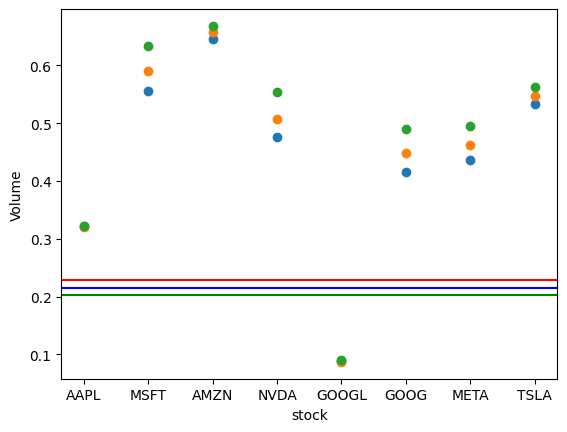

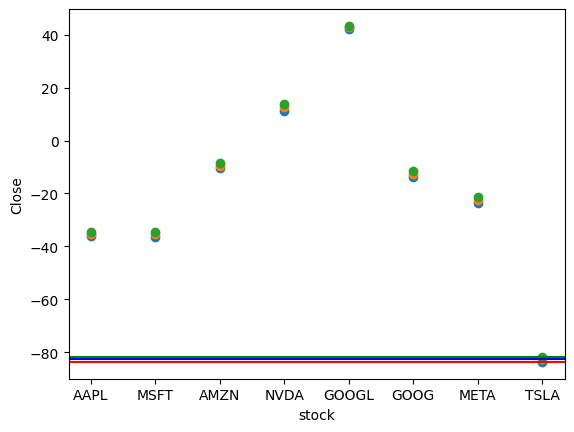

In [260]:
def plot_result_pronostic(df: pd.DataFrame, feature:str, base: dict):
    fig, ax = plt.subplots()
    ax.scatter(result.index, df[(feature,'q10')])
    ax.scatter(result.index, df[(feature,'q50')])
    ax.scatter(result.index, df[(feature,'q90')])
    plt.axhline(y = base[feature]['q10'], color = 'r', linestyle = '-')
    plt.axhline(y = base[feature]['q50'], color = 'b', linestyle = '-')
    plt.axhline(y = base[feature]['q90'], color = 'g', linestyle = '-')
    ax.set_xlabel('stock')
    ax.set_ylabel(feature)
    plt.show()
plot_result_pronostic(result, 'Volume', baseline)
plot_result_pronostic(result, 'Close', baseline)